# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

def reloadTestingData():
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    return (test['features'], test['labels'])

# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import cv2
import matplotlib.image as mpimg

from tensorflow.contrib.layers import flatten
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from collections import deque

signames = pd.read_csv('signnames.csv')


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1], X_train.shape[2]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

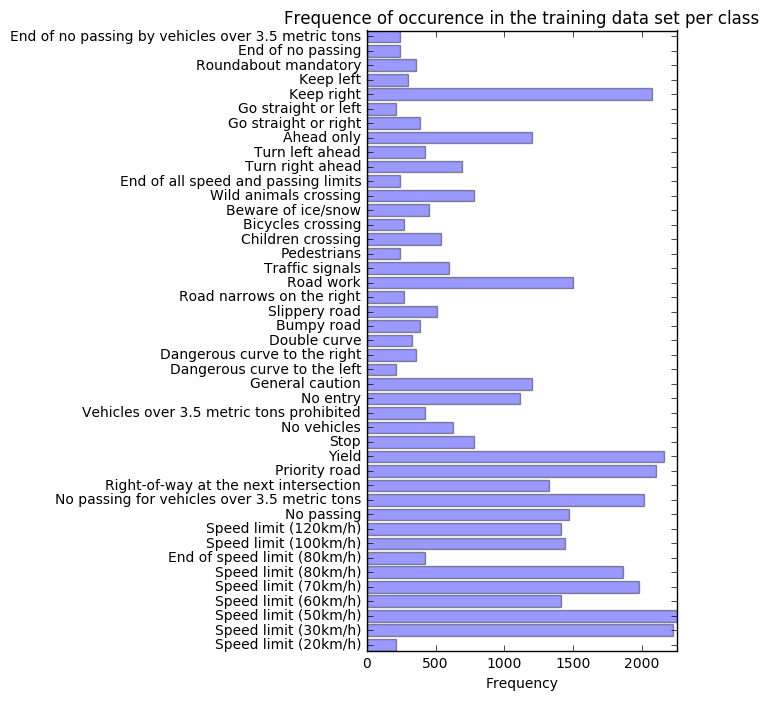

In [3]:
# Plot how many images for every class are in the training set

%matplotlib inline

plt.figure(figsize=(4, 8)) 
y_pos = range(n_classes)
labels = [ signames.SignName[x] for x in y_pos ]
plt.barh(y_pos, np.bincount(y_train), 0.8, align='center', alpha=0.4)
plt.yticks(y_pos, labels)
plt.xlabel('Frequency')
plt.title('Frequence of occurence in the training data set per class')
plt.axis('tight')
plt.show()

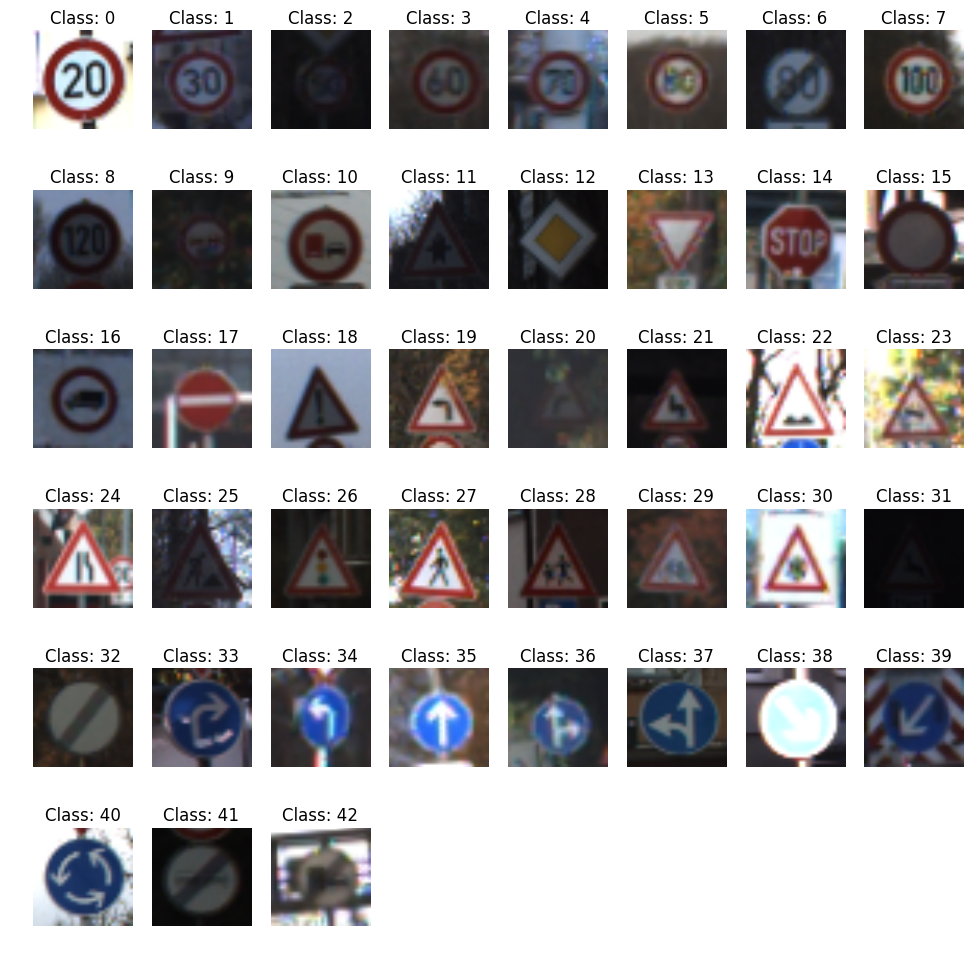

In [4]:
# Plot an example image for every class

signs_numrows = 6
signs_numcolumns = 8

plt.figure(figsize=(12, 12))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(signs_numrows, signs_numcolumns, c+1)
    plt.axis('off')
    plt.title('Class: {}'.format(c))
    plt.imshow(X_train[i])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

In [5]:
EPOCHS = 20
BATCH_SIZE = 128

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

** Features and Labels **

*Taken from the LeNet-Lab*. Replaced hard-coded values with variables.

In [6]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

** Training Pipeline **

*Taken from the LeNet-Lab*

In [7]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

**Model Evaluation**

*Taken from the LeNet-Lab*

In [8]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        
        total_accuracy += (accuracy  * len(batch_x))
    return total_accuracy / num_examples

** Train the Model ** 

*Taken from the LeNet-Lab*


In [9]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2) 

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        validation_accuracy = evaluate(X_validation, y_validation)
        print("Epoch {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

Epoch 1 ...
Validation Accuracy = 0.527
Epoch 2 ...
Validation Accuracy = 0.783
Epoch 3 ...
Validation Accuracy = 0.844
Epoch 4 ...
Validation Accuracy = 0.893
Epoch 5 ...
Validation Accuracy = 0.904
Epoch 6 ...
Validation Accuracy = 0.923
Epoch 7 ...
Validation Accuracy = 0.936
Epoch 8 ...
Validation Accuracy = 0.936
Epoch 9 ...
Validation Accuracy = 0.946
Epoch 10 ...
Validation Accuracy = 0.947
Epoch 11 ...
Validation Accuracy = 0.947
Epoch 12 ...
Validation Accuracy = 0.950
Epoch 13 ...
Validation Accuracy = 0.960
Epoch 14 ...
Validation Accuracy = 0.952
Epoch 15 ...
Validation Accuracy = 0.945
Epoch 16 ...
Validation Accuracy = 0.949
Epoch 17 ...
Validation Accuracy = 0.958
Epoch 18 ...
Validation Accuracy = 0.962
Epoch 19 ...
Validation Accuracy = 0.966
Epoch 20 ...
Validation Accuracy = 0.961
Test Accuracy = 0.877
Model saved


### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

The model implementation is in the answer to question 3.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** For preoprocessing I normalized the images using CLAHE to improve contrast in images. This also makes darker images brighter. Looking at the plotted images it is much easier for a human to identify the signs after CLAHE has been applied. The hope is that the same holds true for the neural net.

In [10]:
# CLAHE implemented using OpenCV

def equalize_hist(img):
    # first attempt with considers global contrast was to aggressive
    # for c in range(0, 2):
    #   img[:,:,c] = cv2.equalizeHist(img[:,:,c])
    
    # inspired from http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(3,3))
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)    
    l,a,b = cv2.split(lab)
    l_corrected = clahe.apply(l)
    lab = cv2.merge((l_corrected,a,b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return img

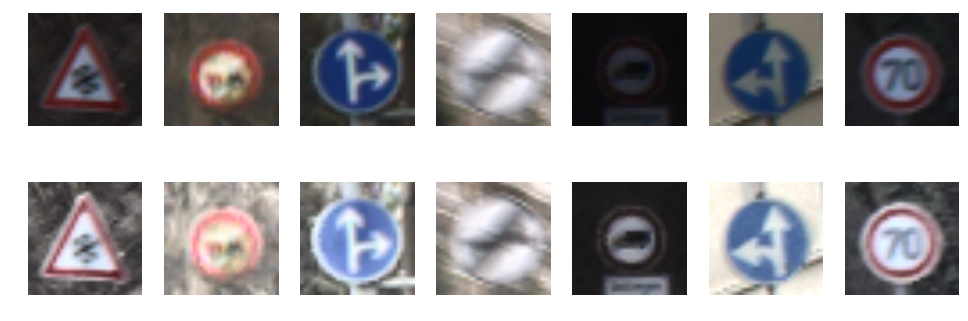

In [11]:
# Apply CLAHE on few random pictures to see the effect

plt.figure(figsize=(12, 4))

signs_numrows = 2
signs_numcolumns = 7
#signs_numcolumns instead of 1
for c in range(signs_numcolumns):
    plt.rc('font', size=7)
    random_image_class = random.randint(0, 43)
    i = random.choice(np.where(y_train == random_image_class)[0])
    image = np.copy(X_train[i])
    image_equalized  = equalize_hist(np.copy(X_train[i]))
    plt.subplot(signs_numrows, signs_numcolumns, c+1)
    plt.axis('off')
    plt.imshow(image)
    plt.subplot(signs_numrows, signs_numcolumns, c+1+signs_numcolumns)
    plt.axis('off')
    plt.imshow(image_equalized)
plt.show()

### Question 2

Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** I generated additional data, because there are some classes for which only few examples available in the training set. More data generally should result in a better model. 

First I defined individual transformations which take an image and produce a new image, which is slighlty different (e.g. a little bit rotated). I made then some helper functions `generate_image` and `generateAdditionalTrainingData` which are used in `prepareTrainingData`. 

The actual setup of training, validation and testing data happens in `prepareTrainingData`. There additional data is generated until I have 3000 images per class in the training set. From these 3000 * 43 = 129000 images, 25800 (20%) images are reserved for validation, the other 80% (103200 images) are used for training. On every image (training, validation, testing) the contrast is improved.

* Training set has (103200, 32, 32, 3) data points
* Training labels set has (103200,) data points
* Validation set has (25800, 32, 32, 3) data points
* Validation labels set has (25800,) data points
* Test set has (12630, 32, 32, 3) data points
* Test label set has (12630,) data points

In [12]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### http://docs.opencv.org/3.1.0/da/d6e/tutorial_py_geometric_transformations.html

def rotate_image(img, abs_max_rotation = 25):
    rows,cols,depth = img.shape  
    
    # Rotate the image by a value between -abs_max_rotation and abs_max_rotation around the image center
    rotation_angle = np.random.uniform(-abs_max_rotation, abs_max_rotation); 
    rotation_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),rotation_angle,1)
    
    img = cv2.warpAffine(img,rotation_matrix,(cols,rows))
    return img

def translate_image(img, trans_range=5):
    rows,cols,depth = img.shape 
    
    tr_x, tr_y = np.random.uniform(-trans_range, trans_range, 2)
    translation_matrix = np.float32([[1,0,tr_x],[0,1,tr_y]])
    img = cv2.warpAffine(img,translation_matrix,(cols,rows))
    return img
    

def perspective_transform(img, perspective_transform_range=5):
    rows,cols,depth = img.shape 
    
    # Perspective Transformation (works a little bit like a zoom here)
    offset_a, offset_b, offset_c, offset_d = np.random.uniform(0, perspective_transform_range, 4)
    pts1 = np.float32([[0+offset_a,0+offset_b],
                       [rows-offset_c,0+offset_d],
                       [0+offset_d,cols-offset_c],
                       [rows-offset_b,cols-offset_a]])
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])
    perspective_matrix = cv2.getPerspectiveTransform(pts1,pts2)

    img = cv2.warpPerspective(img,perspective_matrix,(rows,cols))
    return img

def affine_transform(img, shear_range=5):
    rows,cols,depth = img.shape
    
    offset_a, offset_b, offset_c = np.random.uniform(-shear_range, shear_range, 3)
    pts1 = np.float32([[5+offset_a,5+offset_b],
                       [5+offset_c,27+offset_a],
                       [27+offset_b,16+offset_c]])
    pts2 = np.float32([[5,5],[5,27],[27,16]])

    affine_transform_matrix = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,affine_transform_matrix,(cols,rows))
    return img

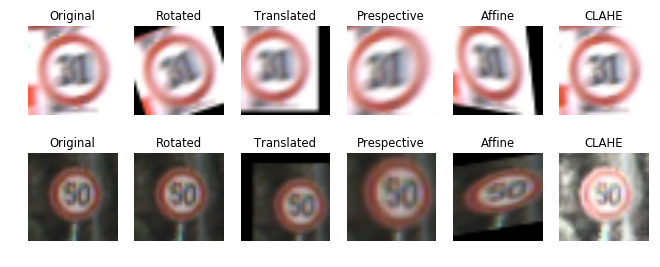

In [13]:
# apply each transformation on an original image for visualization of how the transformations work

plt.figure(figsize=(8, 3))

signs_numrows = 2
signs_numcolumns = 6

for row in range(0, signs_numrows):
        
        # select a random image 
        i = random.choice(np.where(y_train == row+1)[0])
        image = X_train[i]
        plt.subplot(signs_numrows, signs_numcolumns, row * signs_numcolumns  + 1)
        plt.title('Original')
        plt.axis('off')
        plt.imshow(image)
    
        plt.subplot(signs_numrows, signs_numcolumns, row * signs_numcolumns + 2)
        modified_image = rotate_image(np.copy(image))
        plt.title('Rotated')
        plt.axis('off')
        plt.imshow(modified_image)
        
        plt.subplot(signs_numrows, signs_numcolumns, row * signs_numcolumns + 3)
        modified_image = translate_image(np.copy(image))
        plt.title('Translated')
        plt.axis('off')
        plt.imshow(modified_image)
        
        plt.subplot(signs_numrows, signs_numcolumns, row * signs_numcolumns + 4)
        modified_image = perspective_transform(np.copy(image))
        plt.title('Prespective')
        plt.axis('off')
        plt.imshow(modified_image)
        
        plt.subplot(signs_numrows, signs_numcolumns, row * signs_numcolumns + 5)
        modified_image = affine_transform(np.copy(image))
        plt.title('Affine')
        plt.axis('off')
        plt.imshow(modified_image)
        
       
        plt.subplot(signs_numrows, signs_numcolumns, row * signs_numcolumns + 6)
        modified_image = equalize_hist(np.copy(image))
        plt.title('CLAHE')
        plt.axis('off')
        plt.imshow(modified_image)
        
plt.show()

In [14]:
# this function generates a new image from an image by applying ONE random transformation only

def generate_image(img): 
    transformations = {
        0: rotate_image,
        1: translate_image,
        2: perspective_transform,
        3: affine_transform
    }
    
    # Get a transformation randomly
    func = transformations.get(random.randint(0,3))
    
    # Execute the function
    return func(np.copy(img))

In [15]:
# this function generates additional training data from the original training data
# I can specify how many images per class I want to have in my training set

def generateAdditionalTrainingData(target_training_points_per_class, realFeatures, realLabels):
    additional_images = []
    additional_labels = []
    
    inputs_per_class = np.bincount(realLabels)

    for c in range(n_classes):
        training_points_to_be_generated = target_training_points_per_class - inputs_per_class[c]
        
        if(training_points_to_be_generated < 0):
            continue
            
        print("Going to generate {} training points for class: {} ({})".format(training_points_to_be_generated,c,signames.SignName[c]))
        for i in range(training_points_to_be_generated):
        
            # get a random image belonging to the particular class c
            idx = random.choice(np.where(realLabels == c)[0])
            base_image = realFeatures[idx]
        
            # generate artifical image
            artificial_image = generate_image(base_image)
        
            # append artifical image and the respective label to the temp lists
            additional_images.append(artificial_image)
            additional_labels.append(c) 
    
    return (additional_images, additional_labels)

In [16]:
# this function finally sets up the training, validation and testing data sets

def prepareTrainingData():
    
    X_train, y_train = reloadTestingData()
    X_test, y_test = test['features'], test['labels']

    print("Generating artificial images...")
    
    artificial_images, artificial_labels = generateAdditionalTrainingData(3000, X_train, y_train)

    print("Created {} artificial images with {} labels".format(len(artificial_images),len(artificial_labels)))
    
    if(len(artificial_images) > 0):
        X_train = np.append(X_train, np.array(artificial_images), axis=0)
        y_train = np.append(y_train, np.array(artificial_labels), axis=0)

    print("{} images and {} labels available for training and tuning".format(X_train.shape,y_train.shape))
    
    ### Preprocessing of ALL Images

    print("Equalizing histogram...")
    for i in range(len(X_train)):
        equalize_hist(X_train[i])

    for i in range(len(X_test)):
        equalize_hist(X_test[i])
    
    print("Shuffling ...")
    X_train, y_train = shuffle(X_train, y_train)
   
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2) 
    
    print("Training set has {} data points".format(X_train.shape))
    print("Training labels set has {} data points".format(y_train.shape))
    print("Validation set has {} data points".format(X_validation.shape))
    print("Validation labels set has {} data points".format(y_validation.shape))
    print("Test set has {} data points".format(X_test.shape))
    print("Test label set has {} data points".format(y_test.shape))

    return (X_train, X_validation, X_test, y_train, y_validation, y_test)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** My neural net has the following form:

The first three blocks have a similar shape, one-by-one convolution which does not change the depth, convolution layer which increases the depth, and finally max pooling.

* One by one 32x32x3 -> 32x32x3
* Convolution layer 32x32x3 -> 32x32x32
* Pooling layer 32x32x32 -> 16x16x32


* One by one 16x16x32 -> 16x16x32
* Convolution layer 16x16x32 -> 16x16x64
* Pooling layer 16x16x64 -> 8x8x64


* One by one 8x8x64 -> 8x8x64
* Convolution layer 8x8x64 -> 8x8x128
* Pooling layer 8x8x128 -> 4x4x128

To reduce dimensions I am using one-by-one instead of max pooling here

* Convolution layer 4x4x128 -> 4x4x160
* One by one 4x4x160 -> 4x4x80

And finally two fully connected layers

* Fully connected layer 1280 -> 1024

* Fully connected layer 1024 -> 1024


* Output layer 1024 -> 43


In [17]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# CNN helper functions (inspired by the leson TensorFlow Convolution Layer)
def conv2d(x, W_shape, stride=1, mu=0, sigma=0.1, pad='SAME'):
    F_W = tf.Variable(tf.truncated_normal(shape=W_shape, mean=mu, stddev=sigma))
    
    # the value of b and the last value of W represent the output depth
    F_b = tf.Variable(tf.zeros(W_shape[3]))
    
    strides = [1, stride, stride, 1]
    
    x = tf.nn.conv2d(x, F_W, strides, padding = pad)
    x = tf.nn.bias_add(x, F_b)
    x = tf.nn.relu(x)
    return x

# CNN helper functions (inspired by the lesosn TensorFlow Convolution Layer)
def one_by_one_conv2d(x, filter_in, filter_out, stride=1, mu=0, sigma=0.1, pad='SAME'):
    F_W = tf.Variable(tf.truncated_normal(shape=(1,1, filter_in, filter_out), mean=mu, stddev=sigma))
    
    # the value of b and the last value of W represent the output depth
    F_b = tf.Variable(tf.zeros(filter_out))
    
    strides = [1, stride, stride, 1]
    
    x = tf.nn.conv2d(x, F_W, strides, padding = pad)
    x = tf.nn.bias_add(x, F_b)
    x = tf.nn.relu(x)
    return x


def maxpool2d(x, k = 2, pad = 'SAME'):
    x = tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding = pad)
    return x

def fc_with_activation(x, W_shape,  mu = 0, sigma = 0.1):
    x = fc_without_activation(x, W_shape, mu, sigma)
    x = tf.nn.relu(x)
    return x

def fc_without_activation(x, W_shape,  mu = 0, sigma = 0.1):
    fc_W  = tf.Variable(tf.truncated_normal(shape=W_shape, mean = mu, stddev = sigma))
    fc_b  = tf.Variable(tf.zeros(W_shape[1]))
    x    = tf.matmul(x, fc_W) + fc_b
    return x
    

In [18]:
keep_prob = tf.placeholder(tf.float32)

def cnn_traffic_signs(x):
    
    onebyone1 = one_by_one_conv2d(x, filter_in=3, filter_out=3)
    
    # 32x32x3 -> 32x32x32
    conv1 = conv2d(onebyone1, (4, 4, 3, 32))
    
    # 32x32x32 -> 16x16x32
    conv1 = maxpool2d(conv1, k = 2)
    
    # 16x16x32 -> 16x16x32
    onebyone2 = one_by_one_conv2d(conv1, filter_in=32, filter_out=32)
    
    # 16x16x32 -> 16x16x64
    conv2 = conv2d(onebyone2, (3, 3, 32, 64))
    
    # 16x16x64 -> 8x8x64
    conv2 = maxpool2d(conv2)
    
    # 8x8x64 -> 8x8x64
    onebyone3 = one_by_one_conv2d(conv2, filter_in=64, filter_out=64)
    
    # 8x8x64 -> 8x8x128
    conv3 = conv2d(onebyone3, (3, 3, 64, 128))
    
    # 8x8x128 -> 4x4x128
    conv3 = maxpool2d(conv3)
    
    # 4x4x128 -> 4x4x160
    conv4 = conv2d(conv3, (2, 2, 128, 160))
    
    # 4x4x160 -> 4x4x80
    conv4 = one_by_one_conv2d(conv4, filter_in=160, filter_out=80)

    # 4x4x80 -> 1280
    fc0   = flatten(conv4)
    
    # Fully Connected Layer 1. 1280 -> 1024
    fc1 = fc_with_activation(fc0, (1280, 1024))
    
    fc1 = tf.nn.dropout(fc1, keep_prob)
  
    # Fully Connected Layer 2. 1024 -> 1024
    fc2 = fc_with_activation(fc1, (1024, 1024))
    
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Output Layer
    logits  = fc_without_activation(fc1, (1024, 43))

    return logits

In [19]:
# TRAINING, VALIDATION, TESTING DATA

X_train, X_validation, X_test, y_train, y_validation, y_test = prepareTrainingData()

# FEATURES / LABELS
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# TRAINING PIPELINE

learning_rate = tf.placeholder(tf.float32)

logits = cnn_traffic_signs(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

# MODEL EVALUATION

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    VALIDATION_DROPOUT = 1.0
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, loss = sess.run((accuracy_operation, loss_operation), feed_dict={
            x: batch_x, 
            y: batch_y, 
            keep_prob: 1.0})
        
        total_accuracy += (accuracy  * len(batch_x))
        total_loss += (loss  * len(batch_x))
    return total_accuracy / num_examples, total_loss / num_examples

Generating artificial images...
Going to generate 2940 training points for class: 0 (Speed limit (20km/h))
Going to generate 2280 training points for class: 1 (Speed limit (30km/h))
Going to generate 2250 training points for class: 2 (Speed limit (50km/h))
Going to generate 2550 training points for class: 3 (Speed limit (60km/h))
Going to generate 2340 training points for class: 4 (Speed limit (70km/h))
Going to generate 2370 training points for class: 5 (Speed limit (80km/h))
Going to generate 2850 training points for class: 6 (End of speed limit (80km/h))
Going to generate 2550 training points for class: 7 (Speed limit (100km/h))
Going to generate 2550 training points for class: 8 (Speed limit (120km/h))
Going to generate 2520 training points for class: 9 (No passing)
Going to generate 2340 training points for class: 10 (No passing for vehicles over 3.5 metric tons)
Going to generate 2580 training points for class: 11 (Right-of-way at the next intersection)
Going to generate 2310 tra

In [21]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Hyperparameters
BATCH_SIZE = 128
TRAINING_DROPOUT = 0.5

saver = tf.train.Saver()

from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
     # keep track
    five_most_recent_validation_losses = deque(5*[100], 5)
    dynamic_lr = 0.005
    learning_rate_stop = 0.00005
    
    print("Training...")
    epoch = 0
    while True:
        epoch = epoch +1 
        print()
        
        train_features, train_labels = shuffle(X_train, y_train)
        training_loss = 0.0
        training_accuracy = 0.0
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = train_features[offset:end], train_labels[offset:end]
            
            # run the training operation
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5, learning_rate: dynamic_lr})
            
            # how are we doing on the training set?
            acc, loss = sess.run((accuracy_operation, loss_operation), feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            training_loss = training_loss + (loss * len(batch_x))
            training_accuracy = training_accuracy + (acc * len(batch_x))
        
        print("EPOCH {} ...".format(epoch))
        
        # how are we doing on the training set in this epoch?
        training_accuracy = training_accuracy / X_train.shape[0]
        training_loss = training_loss / X_train.shape[0]
        print("Training Accuracy = {:.3f}, Training Loss = {:.3f}".format(training_accuracy, training_loss))
        
        # how are we doing on the validation set?
        validation_accuracy, validation_loss = evaluate(X_validation, y_validation)
        print("Validation Accuracy = {:.3f}, Validation Loss = {:.3f}".format(validation_accuracy, validation_loss))
        
        # adapting learning rate
        five_most_recent_validation_losses.appendleft(validation_loss)
        if(epoch > 5):
            fmrvl_mean = np.mean(five_most_recent_validation_losses) 
            print("Mean value of the most recent five values for validation loss: {:.3f}".format(fmrvl_mean))
            
            if validation_loss > fmrvl_mean:
                dynamic_lr = dynamic_lr / 2
                print("Reducing learning rate to {}".format(dynamic_lr))
                
            if dynamic_lr < learning_rate_stop:
                print("Threshold for learning rate reached. Stopping learning")
                break
        
    test_accuracy, test_loss = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}, Test Loss = {:.3f}".format(test_accuracy, test_loss))
    
    print("Saving model ...") 
    saver.save(sess, './cnn-tsign-2.ckpt')
    print("Model saved.")

Training...

EPOCH 1 ...
Training Accuracy = 0.712, Training Loss = 1.017
Validation Accuracy = 0.867, Validation Loss = 0.415

EPOCH 2 ...
Training Accuracy = 0.936, Training Loss = 0.200
Validation Accuracy = 0.913, Validation Loss = 0.286

EPOCH 3 ...
Training Accuracy = 0.953, Training Loss = 0.148
Validation Accuracy = 0.938, Validation Loss = 0.197

EPOCH 4 ...
Training Accuracy = 0.960, Training Loss = 0.126
Validation Accuracy = 0.832, Validation Loss = 0.663

EPOCH 5 ...
Training Accuracy = 0.959, Training Loss = 0.135
Validation Accuracy = 0.913, Validation Loss = 0.287

EPOCH 6 ...
Training Accuracy = 0.962, Training Loss = 0.122
Validation Accuracy = 0.938, Validation Loss = 0.215
Mean value of the most recent five values for validation loss: 0.330

EPOCH 7 ...
Training Accuracy = 0.964, Training Loss = 0.119
Validation Accuracy = 0.928, Validation Loss = 0.306
Mean value of the most recent five values for validation loss: 0.333

EPOCH 8 ...
Training Accuracy = 0.952, Train

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I sticked mainly with the options shown in the lecture, which is

* AdamOptimizer
* BATCH_SIZE = 128
* TRAINING_DROPOUT = 0.5

I did not use a fixed number of EPOCHS. Instead I was looking at a sliding average of the validation_loss over the last five EPOCHS. If the validation_loss of the current epoch was higher than the sliding average I lowered the learning rate. I started with a learning rate of 0.005 and stopped learning if the learning rate would be decreased below 0.00005.


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** I started with the LeNet architecture. First I spend considerable amount of time on generating additional data and preprocessing. However that did not help as much as I expected. My second thought was the neural net does not have enough capacity. There are much more classes than in MNIST and the images are not grayscale. So I played around with the width of the layers and slightly increased them. This did also not help that much. So I went (at least in my point of view ;)) really big and added couple of layers. What helped was also the introduction of the one by one convolutions. Overall it was trial and error.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

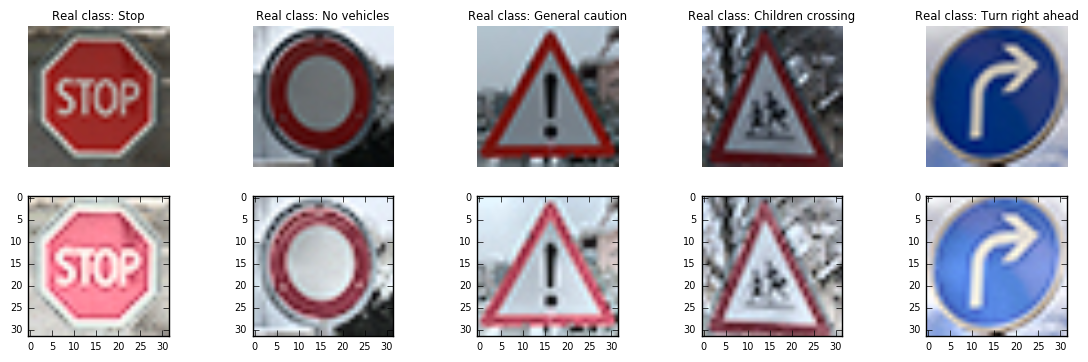

In [22]:
# Project Rubric Criteria: Acquiring New Images

# Loading 5 images I took around Zurich, Switzerland
# I resized them by hand to have size 32x32
# Showing each image in its raw form and normalized. The normalized images can be feed to the network.

extra_images_equalized_hist = []
extra_images_raw = []
extra_labels = []

def loadExtraImage(number):
    img=cv2.imread('extra-signs-data/'+ number +'-resized.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    extra_images_raw.append(img)
    extra_images_equalized_hist.append(equalize_hist(np.copy(img)))
    extra_labels.append(int(number))

loadExtraImage("14");
loadExtraImage("15");
loadExtraImage("18");
loadExtraImage("28");
loadExtraImage("33");
    
X_extra = np.array(extra_images_equalized_hist)
y_extra = np.array(extra_labels)

plt.figure(figsize=(14, 4))

signs_numrows = 2
signs_numcolumns = 5

for i in range(signs_numcolumns):
    
    true_class = signames.SignName[y_extra[i]]
    
    plt.rc('font', size=7)
    plt.subplot(signs_numrows, signs_numcolumns, i+1)
    plt.axis('off')
    plt.title('Real class: {}'.format(true_class))
    plt.imshow(extra_images_raw[i])
    plt.axis('off')
    plt.subplot(signs_numrows, signs_numcolumns, i+1+signs_numcolumns)
    plt.imshow(X_extra[i])

plt.show()

Extra Image Accuracy 1.0000


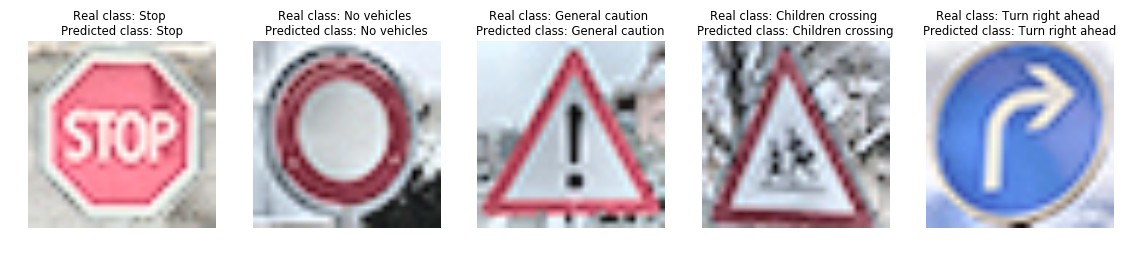

In [23]:
# Project Rubric Criteria: Performance on New Images
# Run the network on the five images and compare predicted to true classes

saver = tf.train.Saver()
BATCH_SIZE = 128
softmax = tf.nn.softmax(logits)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './cnn-tsign-2.ckpt')
    extra_accuracy,_ = evaluate(X_extra, y_extra)
    print("Extra Image Accuracy {:.4f}".format(extra_accuracy))
    batch_x, batch_y = X_extra, y_extra
    feed_dict = {x: batch_x, y: batch_y, keep_prob: 1.0}
    probabilities = sess.run(softmax, feed_dict=feed_dict)
    
    predicted_classes = probabilities.argmax(axis=1)
    
plt.figure(figsize=(14, 4))

for i in range(5):
    plt.rc('font', size=7)
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    predicted_class = signames.SignName[predicted_classes[i]]
    true_class = signames.SignName[y_extra[i]]
    plt.title('Real class: {} \nPredicted class: {}'.format(true_class, predicted_class))
    
    plt.imshow(X_extra[i])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

The images are plotted above. There are five images with the true classes:

* Stop
* No vehicles
* General caution
* Children crossing
* Turn right ahead

The images were taken during the day so the light conditions were pretty good. I could imagine that the image with children crossing is more challenging than the other four, beause the children are very pixelated.


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**  

* Accuracy on the extra data set is 1.0000 (100%)
* Accuracy on the test data set is 0.9998 (100%)
* Accuracy on the training data set is 1.0000 (100%)

My model has been trained for 36 epochs. The training accuracy reached 0.999 already in epoch 26.
Based on this I feared that the model overfits, but the accuracy on the test set was as good as the accuracy on the training set. So there is only a very small gap between accuracy on thes set and on training set which doesn't look like my model overfits. 

In [24]:
saver = tf.train.Saver()

In [27]:
# determineAccuracy is a helper function which calculates the accuracy for the passed data set.

def determineAccuracy(X, y):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, './cnn-tsign-2.ckpt')
        extra_accuracy,_ = evaluate(X, y)
        return extra_accuracy

In [28]:
# Sanity check, I want to make sure that the accuracy on the test set using the restored model
# is the same as the accuracy on the test set after end of training.

print("Test Accuracy {:.4f}".format(determineAccuracy(X_test, y_test)))

Test Accuracy 0.9998


In [29]:
# Project Rubric Criteria:  Model Certainty Visualization
# In the next cells the softmax probabilites will be calculated, then visualized and after that discussed.

# Calculate the softmax probabilities here.

softmax = tf.nn.softmax(logits)
top_five = tf.nn.top_k(softmax, k = 5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './cnn-tsign-2.ckpt')
    batch_x, batch_y = X_extra, y_extra
    feed_dict = {x: batch_x, y: batch_y, keep_prob: 1.0}
    ((top_values, top_indices), probabilities) = sess.run([top_five,softmax], feed_dict=feed_dict)
    
    predicted_classes = probabilities.argmax(axis=1)
    print("True classes:")
    print(batch_y)
    print()
    print("Top 5 predicted classes in descending order per image")
    print(top_indices)
    print()
    print("Softmax probabiliteis for each of the top 5 predicted classes in descending order per image")
    print(top_values)

True classes:
[14 15 18 28 33]

Top 5 predicted classes in descending order per image
[[14 17  0  1  2]
 [15  0  1  2  3]
 [18 26 22 25 12]
 [28 25 24 11 29]
 [33 35 39 32 36]]

Softmax probabiliteis for each of the top 5 predicted classes in descending order per image
[[  1.00000000e+00   1.54153304e-30   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  9.99975204e-01   2.47964817e-05   7.41893214e-09   2.08384217e-14
    1.71861325e-14]
 [  5.87422431e-01   4.05219615e-01   4.25818609e-03   1.78497203e-03
    8.62175017e-04]
 [  1.00000000e+00   8.82141492e-28   2.09092983e-32   1.37161364e-35
    1.86949484e-36]]


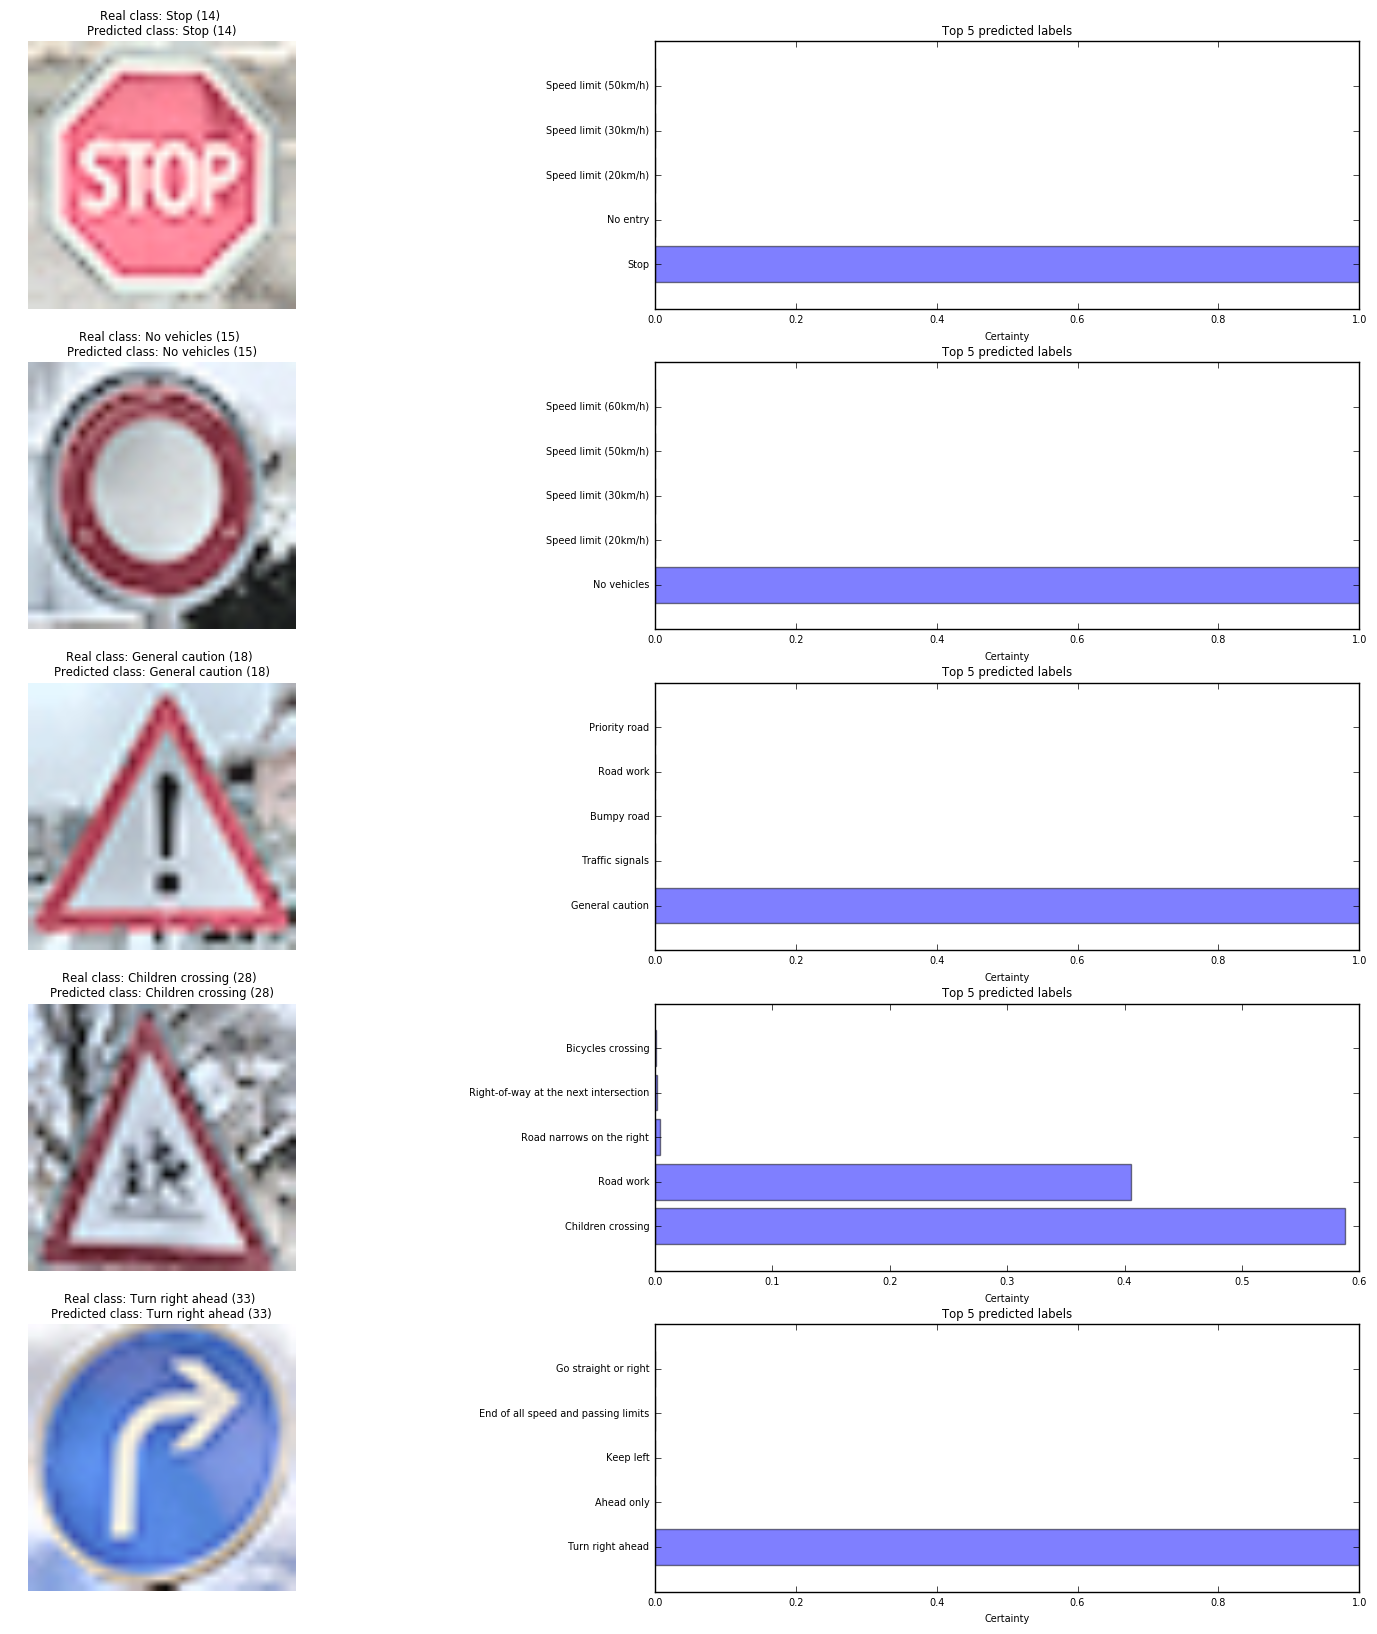

In [30]:
# Visualize the softmax probabilities here.

plt.figure(figsize=(20, 20))
for i in range(0,5):
    plt.rc('font', size=7)
    plt.subplot(5, 2, i*2+1)
    plt.axis('off')
    predicted_class = signames.SignName[predicted_classes[i]]
    true_class = signames.SignName[y_extra[i]]
    plt.title('Real class: {} ({}) \nPredicted class: {} ({})'.format(true_class,y_extra[i], predicted_class,predicted_classes[i]))
    plt.imshow(X_extra[i])
    plt.subplot(5, 2, i*2+2)
    
    top5 = top_indices[i]
    y_pos = np.arange(len(top5))
    probs = top_values[i]
    top5_labels = [ signames.SignName[x] for x in top5 ]
    plt.barh(y_pos, probs, align='center', alpha=0.5)
    plt.yticks(y_pos, top5_labels)
    plt.xlabel('Certainty')
    plt.title('Top 5 predicted labels')

plt.show()

The model has a very high certainty on all the images I took. The exception is the image of the sign "Children crossing" (class 28).

In [35]:
# used for further analysis during tuning 

def generateClassSpecificSet(clazz, X, y):
    
    children_crossing_images = []
    children_crossing_labels = []
    
    indices = np.where(y == clazz)
    for x in indices[0]:
        children_crossing_images.append(X[x])
        children_crossing_labels.append(clazz)
        
    return (children_crossing_images, children_crossing_labels)
        
children_crossing_images, children_crossing_labels = generateClassSpecificSet(28, X_train, y_train)
X_children_crossing = np.array(children_crossing_images)
y_children_crossing = np.array(children_crossing_labels)

accuracy_for_class_28 = determineAccuracy(X_children_crossing, y_children_crossing)
print("Accuracy for class \"{}\" ({}) on specific set is {:.4f}".format(signames.SignName[28], 28, accuracy_for_class_28))

Accuracy for class "Children crossing" (28) on specific set is 1.0000


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [38]:
# helper function to find indices of images in a data set where
# the softmax probability for the predicted class is in a specified range

def getIndiciesOfImagesFilteredByPredictionCertainty(X_data, y_data, low_threshold, high_threshold):
    image_indices = []
    BATCH_SIZE = 128
    num_examples = len(X_data)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, './cnn-tsign-2.ckpt')
    
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            feed_dict = {x: batch_x, y: batch_y, keep_prob: 1.0}
            (top_values, top_indices), _ = sess.run((top_five, softmax), feed_dict=feed_dict)

            for idx in range(len(batch_x)):
                above = np.max(top_values[idx]) >= low_threshold
                below = np.max(top_values[idx]) <= high_threshold
                if(above and below):
                    image_indices.append(offset + idx)
                    
    return image_indices

In [39]:
# counting how many images are predicted with a certainty of 1.0 - 0.95, how many with a certainty of 0.95 - 0.90, ...

X_test, y_test = reloadTestingData()

for i in range(len(X_test)):
    X_test[i] = equalize_hist(X_test[i])

predictions_in_range = []

for i in range(100, 0, -5):
    high_threshold = round(i / 100,2)
    low_threshold =  round(high_threshold - 0.05,2)
    image_indices = getIndiciesOfImagesFilteredByPredictionCertainty(X_test, y_test, low_threshold, high_threshold)
    predictions_in_range.append(len(image_indices))

[11445, 236, 163, 126, 83, 95, 96, 77, 106, 69, 49, 39, 22, 13, 9, 1, 0, 1, 0, 0]


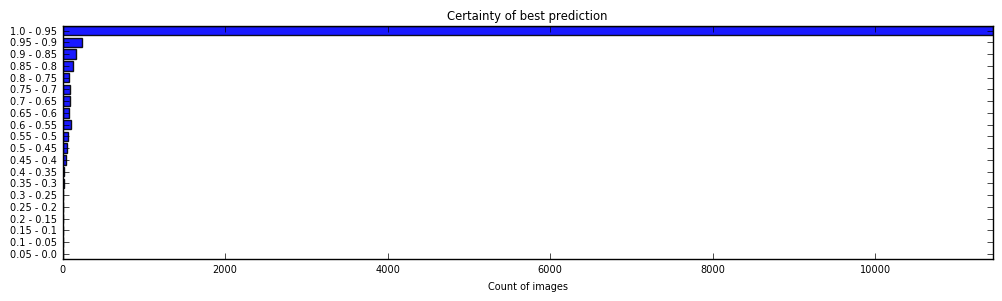

In [40]:
# visualizing the numbers calculated above

print(predictions_in_range)
plt.figure(figsize=(12, 3)) 
y_pos = range(100, 0, -5)
labels = [ "{} - {}".format(round(x/100,2), round(x/100 -0.05,2)) for x in range(100, 0, -5) ]
plt.barh(y_pos, predictions_in_range,height=4, align='center', alpha=0.9)
plt.yticks(y_pos, labels)
plt.xlabel('Count of images')
plt.title('Certainty of best prediction')
plt.axis('tight')
plt.show()

The above chart should be read as follows:
* For 11445 images the certainty of the prediction is between 1.0 and 0.95
* For 236 images the certainty of the prediction is between 0.95 and 0.9
* ....

Overall the model is very certain about the predictions it makes.

Out of curiousity looking at five images where the certainty of predictions is very low (between 0 and 0.4)

In [41]:
# translate the indices to images and labels

X_test, y_test = reloadTestingData()

for i in range(len(X_test)):
    X_test[i] = equalize_hist(X_test[i])

# looking at very problematic images
uncertain_images_indicies = getIndiciesOfImagesFilteredByPredictionCertainty(X_test, y_test, 0.0, 0.4)

# only using the first five problematic images
X_uncertain_images = np.array([ X_test[x] for x in uncertain_images_indicies[0:5]])
y_uncertain_images = np.array([ y_test[x] for x in uncertain_images_indicies[0:5]])


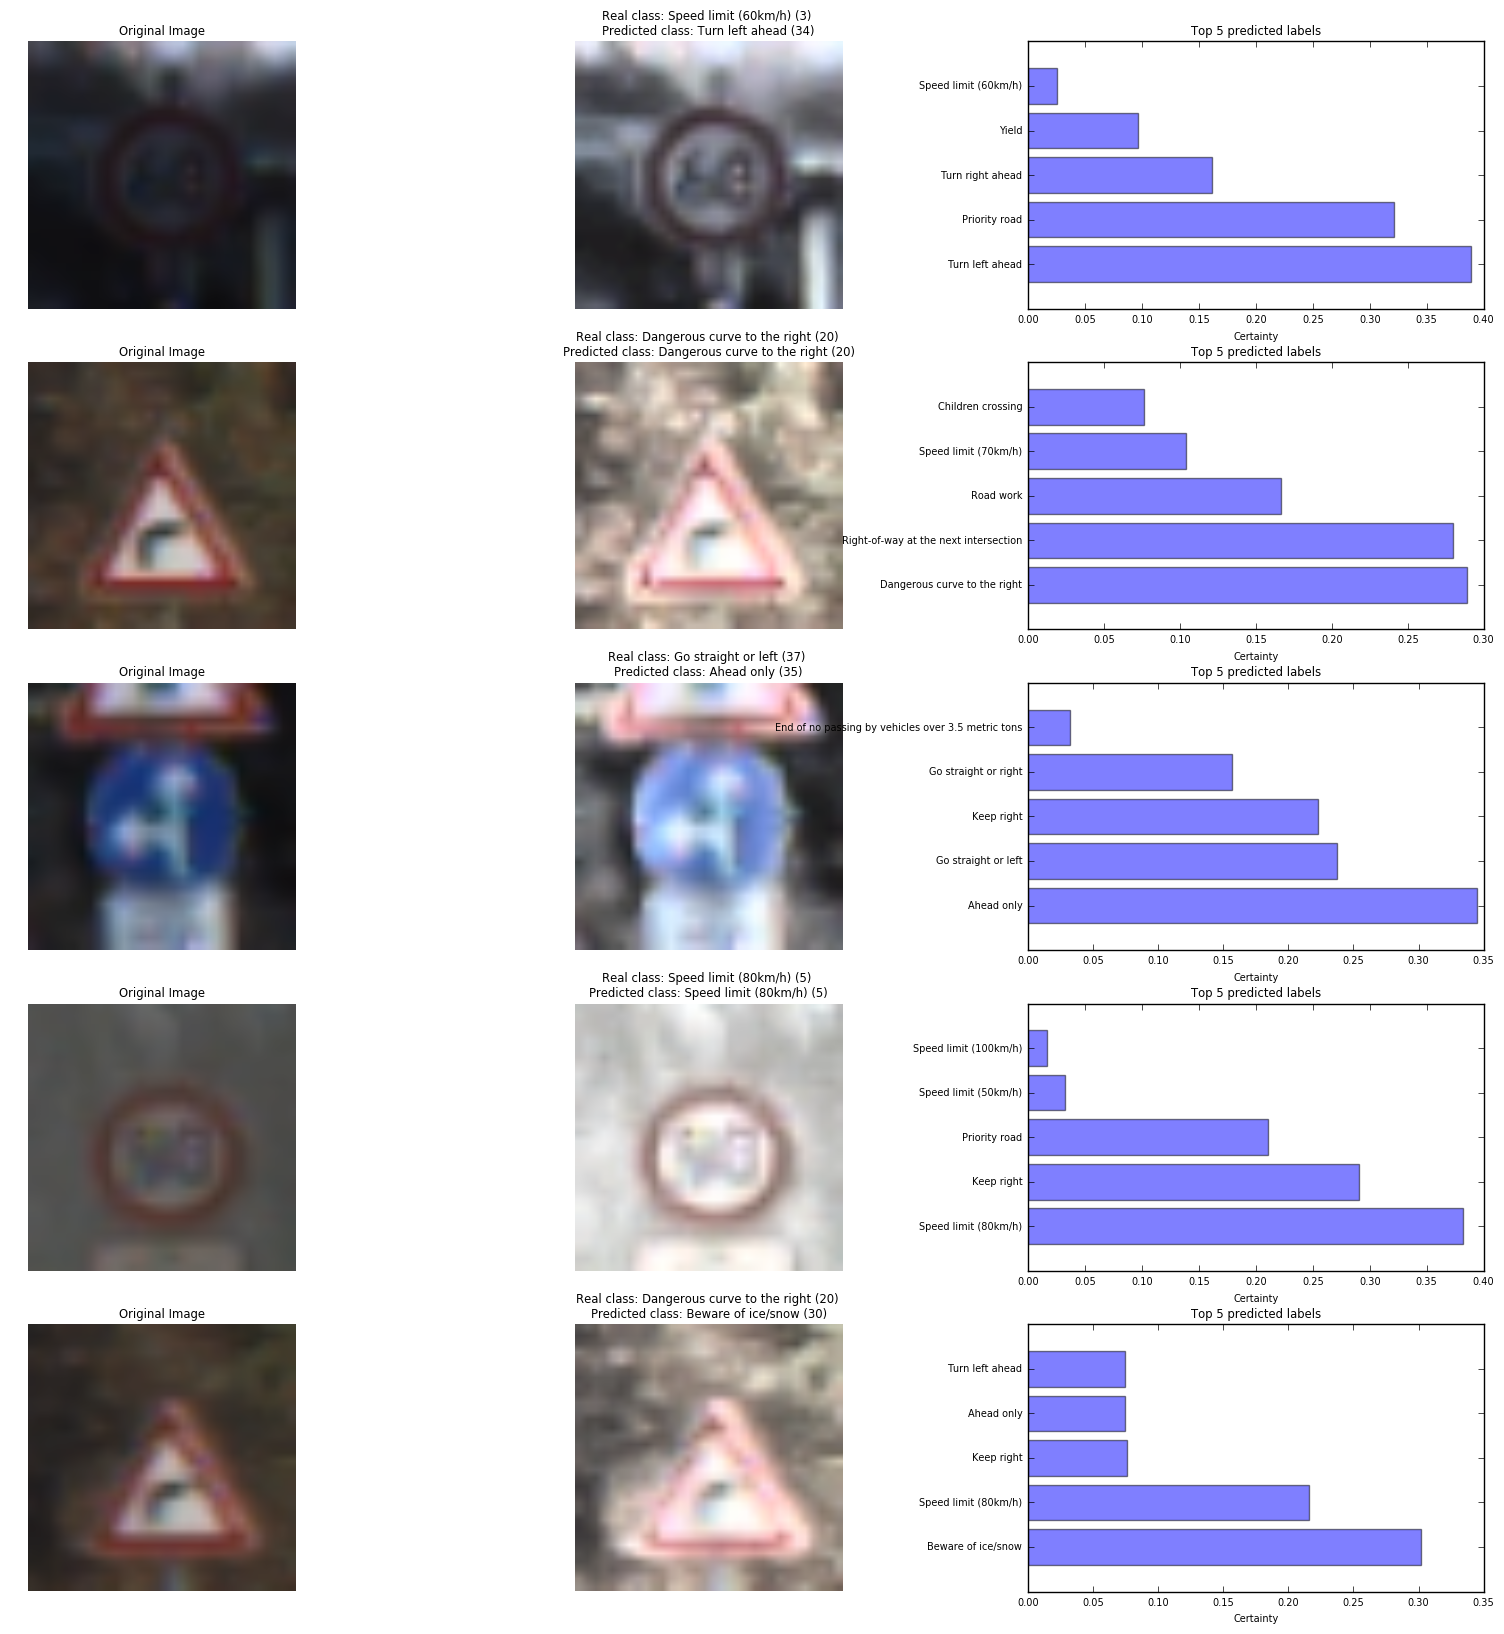

In [43]:
# visualize the problematic images and the probabilities

# get the probabilities
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './cnn-tsign-2.ckpt')
    batch_x, batch_y = X_uncertain_images, y_uncertain_images
    feed_dict = {x: batch_x, y: batch_y, keep_prob: 1.0}
    ((top_values, top_indices), probabilities) = sess.run([top_five,softmax], feed_dict=feed_dict)
    predicted_classes = probabilities.argmax(axis=1)

# for showing the original images without histogram equalization too   
X_test_without_preprocessing, _ = reloadTestingData()

# plot
plt.figure(figsize=(20, 20))
for i in range(0,5):
    plt.rc('font', size=7)
    
    plt.subplot(5, 3, i*3+1)
    plt.axis('off')
    predicted_class = signames.SignName[predicted_classes[i]]
    true_class = signames.SignName[y_uncertain_images[i]]
    plt.title('Original Image')
    plt.imshow(X_test_without_preprocessing[uncertain_images_indicies[i]])
    
    
    plt.subplot(5, 3, i*3+2)
    plt.axis('off')
    predicted_class = signames.SignName[predicted_classes[i]]
    true_class = signames.SignName[y_uncertain_images[i]]
    plt.title('Real class: {} ({}) \nPredicted class: {} ({})'.format(true_class,y_uncertain_images[i], predicted_class,predicted_classes[i]))
    plt.imshow(X_uncertain_images[i])
    
    plt.subplot(5, 3, i*3+3)
    top5 = top_indices[i]
    y_pos = np.arange(len(top5))
    probs = top_values[i]
    top5_labels = [ signames.SignName[x] for x in top5 ]
    plt.barh(y_pos, probs, align='center', alpha=0.5)
    plt.yticks(y_pos, top5_labels)
    plt.xlabel('Certainty')
    plt.title('Top 5 predicted labels')

plt.show()
    

Light conditions have a serious impact on the certainty. All images do not have much contrast even after applyin CLAHE.

* Image 1: Correct class is at position 5 in the Top 5
* Image 2: Correct class is at position 1 in the Top 5, classified correctly but very close to position 2 in the Top 5
* Image 3: Correct class is at position 2 in the Top 5
* Image 4: Correct class is at position 1 in the Top 5, classified correctly
* Image 5: Correct class is not even in the Top 5


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.